In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bloom import *

### Вспомогательные функции

In [78]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

### Загрузка и подготовка данных

In [139]:
vea_res = bdh("PZA1 A:00_0_R INDEX", ["30DAY_IMPVOL_100.0%MNY_DF", "PX_LAST"], date_from = '2010-01-01')

In [210]:
index[0]

Timestamp('2010-01-11 00:00:00', freq='D')

In [212]:
df = pd.DataFrame.from_dict(vea_res)
index = pd.date_range(df['date'].values[0], df['date'].values[-1])
df.index = pd.to_datetime(df['date'])
df.drop(columns=['date'], inplace=True)
df = df.reindex(index=index, method='nearest')

In [216]:
dfnona = df.fillna(method='bfill')

In [217]:
dfnona_1 = pd.concat([dfnona, dfnona.shift()], axis=1)
dfnonashft = dfnona_1.drop(dfnona_1.index[0])
def f(x):
    c = x["PX_LAST"][0]
    c1 = x["PX_LAST"][1]
    return np.log(c/c1)

changes = dfnonashft.apply(f, axis=1).values

In [218]:
dfnona = dfnona.drop(dfnona.index[0])

### Посчитаем HV с n-дневним окном

In [219]:
def calc_hv(changes, n_days):
    n = n_days - 1 # между 30 днями 29 изменений цены
    ch = rolling_window(changes, n)
    dHV = np.sqrt(np.sum((ch - ch.mean(axis=1).reshape(ch.shape[0], 1)) ** 2, axis=1)/(n-1) * 252) * 100
    dHV = np.insert(dHV, 0, np.zeros(n-1))
    return dHV

In [220]:
dfnona['d30HV'] = calc_hv(changes, 30)
dfnona['d15HV'] = calc_hv(changes, 15)

### Посчитаем RV c n-дневним окном

In [221]:
def calc_rv(changes, n_days):
    n = n_days - 1 # между 30 днями 29 изменений цены
    ch = rolling_window(changes, n)
    dRV = np.sqrt(np.sum(ch ** 2, axis=1)/(n-1) * 252) * 100
    dRV = np.insert(dRV, dRV.shape[0], np.zeros(n-1))
    return dRV

In [222]:
dfnona['d30RV'] = calc_rv(changes, 30)

### Рисуем графики

In [223]:
cut = 100

dfnona = dfnona.drop(pd.date_range(dfnona.index[0], dfnona.index[cut]))
dfnona = dfnona.drop(pd.date_range(dfnona.index[-cut], dfnona.index[-1]))

In [226]:
dfnona.iloc[300:].head(20)

,PX_LAST,30DAY_IMPVOL_100.0%MNY_DF,d30HV,d15HV,d30RV
2011-02-17,28319.48,27.12,28.528300,26.743062,23.634810
2011-02-18,28339.71,28.52,27.802462,22.027590,22.862236
2011-02-19,28339.71,28.52,27.715673,22.027590,22.861233
2011-02-20,28810.73,28.81,28.119486,23.920673,22.954485
2011-02-21,28810.73,28.81,27.430201,23.920673,22.415480
2011-02-22,28672.03,29.35,27.492293,23.624243,22.614987
2011-02-23,30140.02,31.08,30.990705,31.542075,22.973813
2011-02-24,30140.02,31.08,29.225784,28.176564,17.451982
2011-02-25,30342.30,30.11,28.676073,28.322665,17.503963
2011-02-26,30342.30,30.11,28.542387,28.322665,17.388558


<AxesSubplot:>

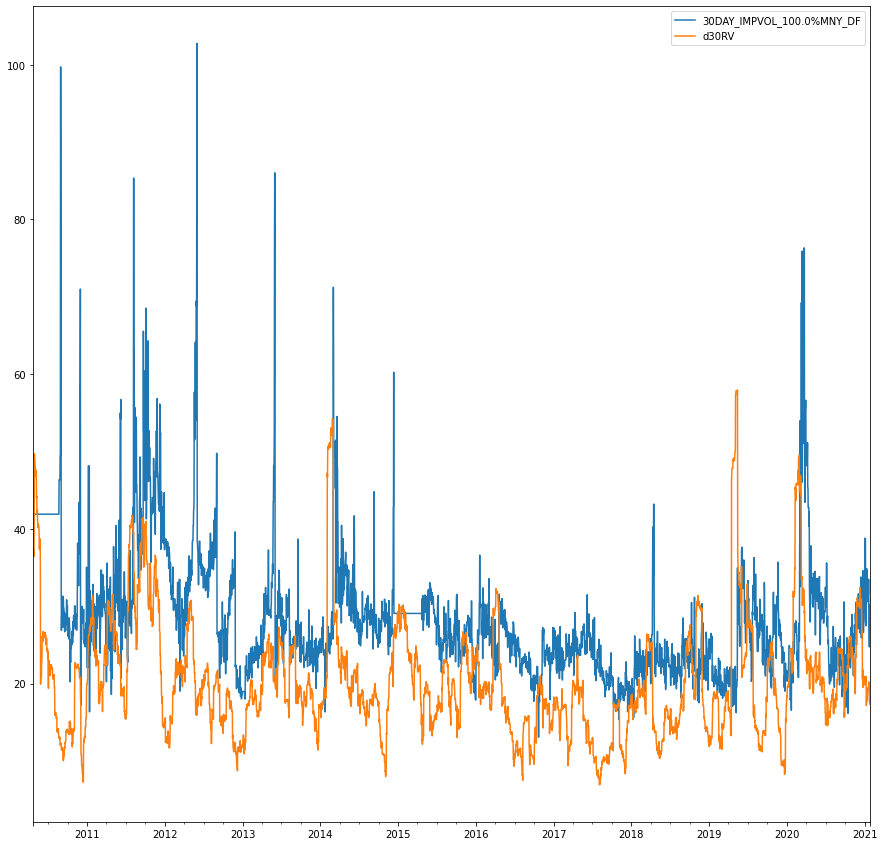

In [227]:
dfnona[['30DAY_IMPVOL_100.0%MNY_DF', 'd30RV']].plot(figsize=(15,15))

<AxesSubplot:>

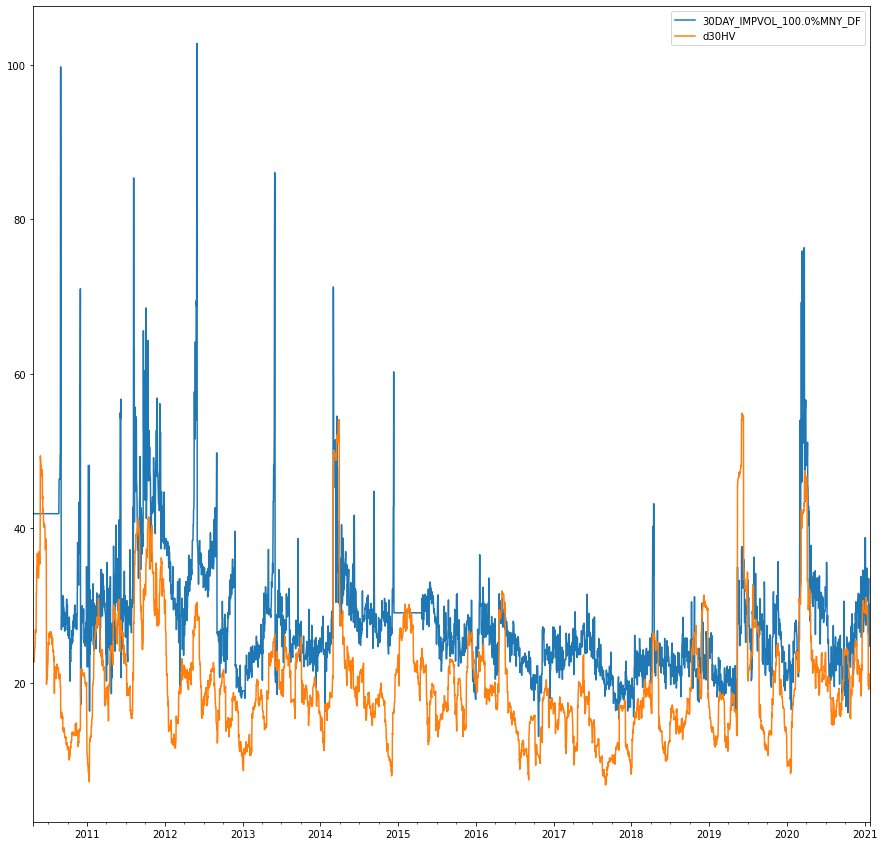

In [228]:
dfnona[['30DAY_IMPVOL_100.0%MNY_DF', 'd30HV']].plot(figsize=(15,15))

In [231]:
dfnona.drop(columns=['PX_LAST']).corr()

,30DAY_IMPVOL_100.0%MNY_DF,d30HV,d15HV,d30RV
30DAY_IMPVOL_100.0%MNY_DF,1.000000,0.572413,0.518730,0.293300
d30HV,0.572413,1.000000,0.819450,0.389345
d15HV,0.518730,0.819450,1.000000,0.387034
d30RV,0.293300,0.389345,0.387034,1.000000
